In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
from collections import Counter
%matplotlib inline

## Data Preprocessing
We can download the 20news data by the tools like fetch_20newsgroup. Note, **we are going to remove the headers and footers in order they contain straightforward words which indicate the labels.**

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers'),
                                  shuffle=True, random_state=11)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers',  'footers'),
                                  shuffle=True, random_state=11)

In [3]:
print('Training text number:', len(newsgroups_train.data))
print('Testing text number:', len(newsgroups_test.data))

Training text number: 11314
Testing text number: 7532


In [4]:
newsgroups_train.target_names[newsgroups_train.target[3]]

'talk.religion.misc'

In [5]:
print(newsgroups_train.data[3])

In article <1r3le9$mlj@horus.ap.mchp.sni.de> frank@D012S658.uucp (Frank O'Dwyer) writes:
>In article <1r22qp$4sk@squick.eitech.com> ekr@squick.eitech.com (Eric Rescorla) writes:
>#In article <1r0m89$r0o@horus.ap.mchp.sni.de> frank@D012S658.uucp (Frank O'Dwyer) writes:
>#>In article <1qvu33$jk3@kyle.eitech.com> ekr@kyle.eitech.com (Eric Rescorla) writes:
>#>#>If almost all people agree that the sun exists (in the usual, uncritical sense),
>#>#>and almost all people agree that  a deal is bad,  it's a reasonable 
>#>#>conclusion that the sun really does exist, and that the deal really is bad.
>#>#I disagree completely. Until rather recently, most people did not
>#>#believe in evolution or the possibility of the atom bomb. Popular
>#>#opinion is notoriously wrong about matters of fact.
>#>True, but nevertheless the basis of all "matters of fact" is overwhelming
>#>popular opinion, and some overwhelming popular opinion *is* fact ("the
>#>sun shines").  If it were not so, physics would be a 

In [6]:
train_text_lenghts =list(map(len, newsgroups_train.data))
test_text_lenghts =list(map(len, newsgroups_test.data))

In [7]:
np.percentile(train_text_lenghts, [3, 15, 25, 50, 75, 95, 98])

array([  109.  ,   294.  ,   436.  ,   820.  ,  1512.75,  4393.75,  8301.92])

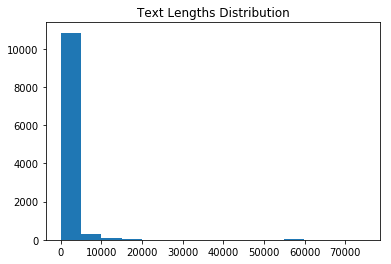

In [8]:
_ = plt.hist(train_text_lenghts, bins=15)
_ = plt.title('Text Lengths Distribution')

The majority of texts have lengths less than 10000.

## Split News intp Sentences

In [9]:
import re
import nltk
import nltk.data
class splitTexts:
    '''Split articles into sentences'''
    def __init__(self):
        self.tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        
    def __preprocess(self, text):
        pattern1 = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,5}'
        regex1 = re.compile(pattern1, flags=re.IGNORECASE)
        text = regex1.sub('email', text)
        pattern2 = '[|#$@><=+-]'
        regex2 = re.compile(pattern2)
        text = regex2.sub(' ', text)
        pattern3 = r'\n'
        regex3 = re.compile(pattern3)
        text = regex3.sub(' ', text)
        pattern4 = r'[ ]+'
        regex4 = re.compile(pattern4)
        text = regex4.sub(' ', text)
        return text.lower()
    
    def split(self, text):
        text = self.__preprocess(text)
        sentences = self.tokenizer.tokenize(text)
        return sentences
        

In [10]:
splitSent = splitTexts()
train_news_sents = [splitSent.split(news) for news in newsgroups_train.data]
test_news_sents = [splitSent.split(news) for news in newsgroups_test.data]

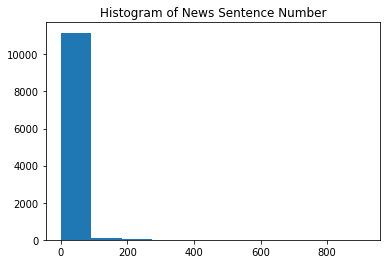

In [11]:
#Calculate the lengths of each news
news_sent_num = list(map(len, train_news_sents))
_ = plt.hist(news_sent_num, bins=10)
plt.title('Histogram of News Sentence Number')

In [12]:
np.percentile(news_sent_num, [25, 50, 75, 95])

array([  4.,   8.,  14.,  40.])

Most news has less than 100 sentences. Actually, 95% news has less than 40 sentences. We need to remove those news with a lot of sentences because two much length may counter the memory of RNNmodel.

In [13]:
min(news_sent_num)

0

## Split sentences into words

First, we need to filter out those news without much information, namely news of one or two words.

In [14]:
train_data = list(zip(train_news_sents, newsgroups_train.target))
test_data = list(zip(test_news_sents, newsgroups_test.target))

Remove news with  more than 50 sentences.

In [15]:
#Filter those empty texts and texts of too many sentences
train_data = list(filter(lambda x: len(x[0])>0 and len(x[0])<50, train_data))
test_data = list(filter(lambda x: len(x[0])>0 and len(x[0])<50, test_data))

In [16]:
print('Training Sample Number', len(train_data))
print('Testing Sample Number', len(test_data))

Training Sample Number 10897
Testing Sample Number 7287


Dozens of news has been filtered out due to the small size.

In [17]:
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer

class splitSent:
    def __init__(self):
        self.tokenizer = WordPunctTokenizer().tokenize
        self.lemmatizer = WordNetLemmatizer().lemmatize
        
    def __preprocess(self, sent):
        return None
    
    def split(self, sent):
        '''
        Split a sentence into words
        Lemmatize words
        '''
        words = self.tokenizer(sent)    
        words = list(map(self.lemmatizer, words))
        return words
    
    def splitList(self, sents):
        sents_words = list(map(self.split, sents))
        return sents_words
        

In [18]:
splitsent = splitSent()
splitsent.split('I love dogs and cats very much!')

['I', 'love', 'dog', 'and', 'cat', 'very', 'much', '!']

We tokenize each sentence into words and punctuations.

In [19]:
hier_train_data = [(splitsent.splitList(item[0]), item[1]) for item in train_data]
hier_test_data = [(splitsent.splitList(item[0]), item[1]) for item in test_data]

## Transform words to IDs

Words and sentences are tokens which can be understood by humans but not computers. Therefore, we need to transform them into numbers that can be handled by computers. First of all, we need to build a vocabulary and map each word to an ID, then we can represent each sentence with a sequence of IDs.

In [20]:
import itertools
from collections import Counter, Iterable
class text2ids:
    '''
    Provide tools to split sents and build vocabulary
    To map a sent into sequence if Ids
    '''
    def __init__(self):
        pass

    
    def __buildVocabulary(self, text, vocab_size, min_freq):
        '''Unlist all the nested list and build a vocabulary'''
        tokens = []
        for sent in text:
            for words in sent:
                tokens.extend(words)
        #tokens = list(itertools.chain.from_iterable(text))
        token_freq = Counter(tokens)
        token_freq_set = token_freq.most_common(vocab_size-1)
        vocab =[k for k, v in token_freq_set if v>=min_freq]
        if 'UNK' not in vocab:
            vocab.append('UNK')
        return vocab
    
    def token2ix(self, text, vocab_size=10000, min_freq=2):
        vocab = self.__buildVocabulary(text, vocab_size, min_freq)
        #Map each char into an ID
        word_id_map = dict(zip(vocab, range(len(vocab))))
        #Map each ID into a word
        id_word_map = dict(zip(word_id_map.values(), word_id_map.keys()))
        return word_id_map, id_word_map, vocab
        
    def sent2ids(self, word_id_map, sent):
        def word2id(c):
            try:
               ID = word_id_map[c]
            except:#Trun those less frequent words into UNK
               ID = word_id_map['UNK']
            return ID
        
        ids = [word2id(item) for item in sent]
        return ids
    
    def sents2sent(self, word_id_map, sents):
        sents_ids = []
        for sent in sents:       
            ids = self.sent2ids(word_id_map, sent)
            sents_ids.append(ids)
        return sents_ids
        
    def texts2sents(self, word_id_map, texts):
        texts_ids = []
        for text in texts:       
            ids = self.sents2sent(word_id_map, text)
            texts_ids.append(ids)
        return texts_ids

In [21]:
class dataTransform(text2ids):
    '''
    An object of news data
    Transform texts into lists of ids
    '''
    def __init__(self, train_text, test_text, vocab_size=10000, min_freq=2):
        self.train_text = train_text
        self.test_text = test_text
        self.vocab_size= vocab_size
        self.min_freq = min_freq
        self.__buildVocabulary()
    
    def __buildVocabulary(self):
        '''Unlist all the nested list and build a vocabulary'''
        self.word_id_map, self.id_word_map, self.vocab = self.token2ix(self.train_text, 
                                                                                self.vocab_size, 
                                                                                self.min_freq)
        
    def text2ids(self):
        '''
        Transform texts into sentences of words
        '''
        train_sents_ids = self.texts2sents(self.word_id_map, self.train_text)
        test_sents_ids = self.texts2sents(self.word_id_map, self.test_text)
        return train_sents_ids, test_sents_ids
    
    def vocabularyMap(self):
        return self.word_id_map, self.id_word_map, self.vocab
        

In [22]:
hier_train_text, hier_train_label = list(zip(*hier_train_data))
hier_test_text, hier_test_label = list(zip(*hier_test_data))

In [24]:
#Transform texts of hierarchical lists of words
dt = dataTransform(hier_train_text, hier_test_text)
train_sents_ids, test_sents_ids = dt.text2ids()
word_id_map, id_word_map, vocab = dt.vocabularyMap()

Now that we have transform words into IDs, we can take a look at the lengths of sentences.

In [25]:
sents_lengths = []
for text in train_sents_ids:
    for sents in text:
            sents_lengths.append(len(sents))

In [26]:
print('Max Length', max(sents_lengths))
print('Min Length', min(sents_lengths))

Max Length 8263
Min Length 1


In [27]:
np.percentile(sents_lengths, [5, 15, 25, 50, 75, 99])

array([  3.,   7.,  10.,  17.,  27.,  82.])

Most sentences have less than 100 words whereas the maximum length is 8263 and the minimum is 1, quite unusual. 

In [28]:
def judgeLength(data):
    text = data[0]
    lengths = []
    #print(text)
    for sents in text:
        lengths.append(len(sents))
    flag = max(lengths) < 82
    return flag

Compress the text IDs and labels into one list.

In [29]:
hier_train_data = list(zip(train_sents_ids, hier_train_label))
hier_test_data = list(zip(test_sents_ids, hier_test_label))

In [30]:
#Filter those news with extreme long sentences
hier_train_data = list(filter(judgeLength, hier_train_data))
hier_test_data = list(filter(judgeLength, hier_test_data))

In [31]:
max(map(len, train_sents_ids))

49

In [146]:
#Save files in local disk
import pandas as pd
train_data_processed = {'text':hier_train_text, 'label':hier_train_label}
test_data_processed = {'text':hier_test_text, 'label':hier_test_label}
td = pd.DataFrame(train_data_processed)
td.to_csv('training_data_processed.csv', index=False)
td = pd.DataFrame(test_data_processed)
td.to_csv('testing_data_processed.csv', index=False)

A news can have as many as 49 sentences atmost.

In [145]:
print('Counts of Training Data:', len(hier_train_data), ' Counts of Testing Data:', len(hier_test_data))

Counts of Training Data: 9882  Counts of Testing Data: 6756


## Data Split

In order to evaluate the performances of our models, we need to divide our training set into training part and validation part. The validation part of texts share the same distributions of training part, so it is likely to use them to check whether the model is overfitting.

In [119]:
from sklearn.model_selection import train_test_split
news_vecs, news_labels = list(zip(*hier_train_data))
training_text_vecs, validation_text_vecs, training_text_labels, validation_text_labels = \
                                                              train_test_split(news_vecs, news_labels, test_size=160, random_state=111)

In [129]:
hier_train_data = list(zip(training_text_vecs, training_text_labels))
hier_valid_data = list(zip(validation_text_vecs, validation_text_labels))

## News to IDs

In [32]:
def word2id(c):
    try:
        ID = word_id_map[c]
    except:#Trun those less frequent words into UNK
        ID = word_id_map['UNK']
    return ID
def id2word(c):
    try:
        word = id_word_map[c]
    except:
        word='UNK'
    return word

It seems the length varies much, perhaps we need buckets to put news with similar lengths together.

## Create Batch Data Generator

In [121]:
import random
class generateSamples:
    '''Generate samples for training and testing'''
    
    def __init__(self, hier_data, max_len=100):
        '''Pass batch size and poems vectors'''
        news_vecs, news_labels = list(zip(*hier_data))
        self.index = 0
        self.news_vecs = news_vecs
        self.news_labels = news_labels
        self.news_count = len(news_vecs)
        self.max_sent_len = max_len
        
    def generate_batch(self, batch_size=64, is_training=True):
        '''Generate a training sample each time'''
        
        selected_samples = []
        selected_labels = []
        batch_weights = []
        #For training, select random samples
        if is_training:
            selected_index = np.random.choice(len(self.news_vecs), batch_size, replace=True)
            for index in selected_index:
                selected_samples.append(self.news_vecs[index])
                selected_labels.append(self.news_labels[index])

        #For testing, select a few samples each time
        else:#Testing model
            start = self.index%self.news_count
            end = (start + batch_size)%self.news_count
            #In case end goes beyong the range of the samples
            if end > start:
                selected_samples = self.news_vecs[start: end]
                selected_labels = self.news_labels[start: end]
                self.index = end
            else:
                print('Test Samples come to an end!')
                selected_samples = self.news_vecs[start: ]
                selected_labels = self.news_labels[start: ]
                self.index = 0
            
        #Find the maximun number of sentences in one text
        max_sent_count = max(map(len, selected_samples))
        #Find the longest sentence and record the length
        find_max_len = lambda x: max(map(len, x))
        max_sent_length = max(map(find_max_len, selected_samples))
        #Record sentence number for each text
        max_sent_count = 49
        #Get the max length in current batch
        #Three level lengths
        text_sent_lengths = []
        text_sent_vectors = []
        for sample in selected_samples:
            #Create input and label
            sent_lengths = []
            sent_vectors = []
            for sent in sample:
                x = np.full((self.max_sent_len), word2id('UNK'), np.int32)
                #Record lengths of each sentence
                sent_lengths.append(len(sent))
                #Transform a list to a vector
                x[:len(sent)] = np.array(sent)
                sent_vectors.append(x)
            #Record each sentence information for each text
            text_sent_lengths.append(sent_lengths)
            text_sent_vectors.append(sent_vectors)
            
        text_sent_labels = np.array(selected_labels)

        return text_sent_vectors, text_sent_labels, text_sent_lengths
    

In [122]:
class generateTextSequences:
    '''Generate samples for training and testing'''
    
    def __init__(self, hier_data, max_sent_len=82, max_sent_count=49):
        '''Pass batch size and poems vectors'''
        news_vecs, news_labels = list(zip(*hier_data))
        self.index = 0
        self.news_vecs = news_vecs
        self.news_labels = news_labels
        self.news_count = len(news_vecs)
        self.max_sent_len = max_sent_len
        self.max_sent_count = max_sent_count
        
    def generate_batch(self, batch_size=32, is_training=True):
        '''Generate a training sample each time'''
        
        selected_samples = []
        selected_labels = []
        batch_weights = []
        #For training, select random samples
        if is_training:
            selected_index = np.random.choice(len(self.news_vecs), batch_size, replace=True)
            for index in selected_index:
                selected_samples.append(self.news_vecs[index])
                selected_labels.append(self.news_labels[index])

        #For testing, select a few samples each time
        else:#Testing model
            start = self.index%self.news_count
            end = (start + batch_size)%self.news_count
            #In case end goes beyong the range of the samples
            if end > start:
                selected_samples = self.news_vecs[start: end]
                selected_labels = self.news_labels[start: end]
                self.index = end
            else:
                print('Test Samples come to an end!')
                selected_samples = self.news_vecs[start: ]
                selected_labels = self.news_labels[start: ]
                self.index = 0
            
        #Find the maximun number of sentences in one text
        #max_sent_count = max(map(len, selected_samples))
        max_sent_count = self.max_sent_count
        #Find the longest sentence and record the length
        find_max_len = lambda x: max(map(len, x))
        #max_sent_length = max(map(find_max_len, selected_samples))
        max_sent_length = self.max_sent_len
        #Get the max length in current batch
        #Three level lengths
        text_sent_vectors = np.full((batch_size, max_sent_count, max_sent_length), word2id('UNK'), np.int32)
        text_sent_lengths = np.full((batch_size, max_sent_count), 0, np.int32)
        for i, sample in enumerate(selected_samples):
            #Create input and label
            for j, sent in enumerate(sample):
                #Record lengths of each sentence
                text_sent_lengths[i, j] = len(sent)
                #Transform a list to a vector
                text_sent_vectors[i, j, :len(sent)] = np.array(sent)
            
        text_sent_labels = np.array(selected_labels)

        return text_sent_vectors, text_sent_labels, text_sent_lengths
    

In [123]:
gs_train = generateTextSequences(hier_train_data)
train_text_vectors, train_text_labels, train_text_lengths = gs_train.generate_batch()
gs_test = generateTextSequences(hier_test_data)
test_text_vectors, test_text_labels, test_text_lengths = gs_test.generate_batch(is_training=False)

From the data exploration, it is clear that the length of the news varies much, ranging from 10 to 10000. In order to deal with that case, we can take buckets into consideration, similar to seq2seq model.

In [124]:
class trainConfig:
    vocab_size = len(vocab)
    max_sent_len = 82
    label_size = 20
    embed_size = 64
    batch_size = 16
    layer_size = 2
    max_sent_count = 49

In [125]:
class testConfig:
    vocab_size = len(vocab)
    max_sent_len = 82
    label_size = 20
    embed_size = 64
    batch_size = 16
    layer_size = 2
    max_sent_count = 49
    
class singleConfig:
    vocab_size = len(vocab)
    max_sent_len = 82
    label_size = 20
    embed_size = 64
    batch_size = 1
    layer_size = 2
    max_sent_count = 49

## Dynamic Hierarchical RNN Model

In this model, we view each text as a series of sentences and each sentence consists of a sereies of words. First, we use word vectors of a sentence to feed LSTM to generate a sentence vector, then we use sentence vectors to generate a text vector.

In [126]:
import functools
from tensorflow.contrib.layers.python.layers import encoders
def lazy_property(function):
    attribute = '_cache_' + function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator

In [127]:
#Reference:http://blog.csdn.net/u010223750/article/details/71079036
from tensorflow.contrib import rnn
class HierarchicalRNN_Model:
    def __init__(self, config, x, y, lengths, is_training=True):
        self.x = x
        self.y = y
        self.vocab_size = config.vocab_size
        self.embed_size = config.embed_size
        self.label_size = config.label_size
        self.batch_size = config.batch_size
        self.lengths = lengths
        self.max_sent_len = config.max_sent_len
        self.max_sent_count = config.max_sent_count
        self.is_training = is_training
        self.predict
        if is_training:
            self.optimize
        print('Model Initialized!')
    
    @lazy_property
    def cost(self):
        logits = self.inference
        targets = tf.one_hot(self.y, 20, 1, 0)
        targets = tf.cast(targets, tf.float32)
        #Note  tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=activation)
        loss = tf.losses.softmax_cross_entropy(targets, logits)
        return loss
    
    @lazy_property
    def predict(self):
        logits = self.inference
        #probs = tf.nn.softmax(logits)
        predictions = tf.argmax(logits, 1)
        return predictions
    
    @lazy_property
    def correct_num(self):
        prediction = self.predict
        targets = tf.reshape(self.y, [-1])
        targets = tf.cast(targets, tf.int64)
        correct_prediction = tf.equal(prediction, targets)
        correct_num = tf.reduce_sum(tf.cast(correct_prediction, "float"))
        return correct_num
    
    @lazy_property
    def optimize(self):
        with tf.variable_scope('optimizer'):
            cost = self.cost
        #with tf.name_scope('Optimizer'):
            #self._learning_rate = tf.Variable(0.0, trainable=False)
            train_op = tf.train.AdamOptimizer(0.0005).minimize(cost)
            #train_op = tf.train.AdamOptimizer(self._learning_rate).minimize(cost)
            #tvars = tf.trainable_variables()
            #grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), 6)
            #optimizer = tf.train.AdamOptimizer(self._learning_rate)
            #train_op = optimizer.apply_gradients(zip(grads, tvars))
        return train_op
    
            
    
    @lazy_property
    def inference(self):
        '''
        Transform each text into a vector on basis of sentence vectors
        '''
        #Create embedding matrix
        with tf.variable_scope('Embeddings'):
            with tf.device("/cpu:0"):
                embeddings = tf.get_variable('embedding', [self.vocab_size,  self.embed_size])
                inputs = tf.nn.embedding_lookup(embeddings, self.x)
        if self.is_training:
            inputs = tf.nn.dropout(inputs, 0.5)

        #slice inputs into a series of vectors
        #batch_doc_vectors = tf.unstack(inputs, axis=0)
        def lstm():
            cell = rnn.BasicLSTMCell(self.embed_size, forget_bias=0.0, 
                                      state_is_tuple=True) 
            if self.is_training:
                cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.5)
            return cell
        with tf.variable_scope('RNN_Word_Layer'):      
            #cell = rnn.MultiRNNCell([lstm_cell() for _ in range(2)], 
                                #state_is_tuple=True)
            cell_word = rnn.MultiRNNCell([lstm()],  state_is_tuple=True)

        #Get the size
        #(document_size, sentence_size, word_size) = tf.unstack(tf.shape(self.x))
        #Dynamic RNN with given lengths for each text
        #Get RNN vector for each sentence
        text_states = []
        for i in range(self.batch_size):
            input_text = inputs[i]
            initial_state_word = cell_word.zero_state((self.max_sent_count), tf.float32)
            #Pass the lengths of each sentence
            outputs_word, status_word = tf.nn.dynamic_rnn(cell_word, input_text, initial_state=initial_state_word,
                                                sequence_length=self.lengths[i], dtype=tf.float32)
            
            #Get the final hidden state
            final_status_word = status_word[-1].h
            #For debugging
            #self.final_status = final_status
            #print(status_concat)
            #Use mean hidden state of sent states as the text hidden state
            #text_hidden_state = tf.reduce_mean(final_status, axis=0)
            #Use sent hidden states to feed another LSTM
            text_states.append(final_status_word)
        #Pass the sentence hidden vector into a LSTM
        text_states = tf.stack(text_states)
        #Get the number of sentences of each text
        great_num = tf.greater(self.lengths, 0)
        great_num = tf.cast(great_num, tf.int32)
        text_sent_num = tf.reduce_sum(great_num, axis=1)
        #Now view a text as a series of sentence vectors
        with tf.variable_scope('RNN_Sent_Layer'):      
            #cell = rnn.MultiRNNCell([lstm_cell() for _ in range(2)], 
                                #state_is_tuple=True)
            cell_sent = rnn.MultiRNNCell([lstm()],  state_is_tuple=True)
            initial_state_sent = cell_sent.zero_state((self.batch_size), tf.float32)
            outputs_sent, status_sent = tf.nn.dynamic_rnn(cell_sent, text_states, initial_state=initial_state_sent,
                                                      sequence_length=text_sent_num,
                                                      dtype=tf.float32)
                
            
        output = status_sent[-1].h
        
        #output = outputs[:,-1,:]
        #If we use padding, the last output will be based on the padding input values
        #Note here we use the hidden state instead of the last output
        #In dynamic rnn, the last state will remain the same after specified time steps
        #For example, if the length is 10 and the padding sequence has 20 words, the 
        #final state will be the one of 10th time step
        #Multilayer RNN has multilayer hidden states
        #output = status[1].h
        
        
        weights = tf.get_variable('weights', [self.embed_size, self.label_size], dtype=tf.float32)
        biases = tf.get_variable('biases', [self.label_size], dtype=tf.float32)
        logits = tf.matmul(output, weights) + biases
        #预测值
        return logits
    
    @property
    def learningRate(self):
        return self._learning_rate
        

In [113]:
graph_rnn = tf.Graph()
#Create models for training and testing data
with graph_rnn.as_default():
    initializer = tf.random_uniform_initializer(-0.02, 0.02)
    with tf.name_scope('train'):
        train_texts = tf.placeholder(tf.int32, [trainConfig.batch_size, None, None])
        train_label = tf.placeholder(tf.int32, [trainConfig.batch_size])
        train_lengths = tf.placeholder(tf.float32, [trainConfig.batch_size, None])
        #Set different models for different buckets
        with tf.variable_scope("Model", reuse=None, initializer=initializer):
            train_model = HierarchicalRNN_Model(trainConfig, train_texts, train_label, train_lengths)


Model Initialized!


In [114]:
with graph_rnn.as_default():
    with tf.name_scope('test'):
        test_texts = tf.placeholder(tf.int32, [testConfig.batch_size, None, None])
        test_label = tf.placeholder(tf.int32, [testConfig.batch_size])
        test_lengths = tf.placeholder(tf.float32, [testConfig.batch_size, None])
        single_text = tf.placeholder(tf.int32, [1, None, None])
        single_label = tf.placeholder(tf.int32, [1])
        single_lengths = tf.placeholder(tf.float32, [1, None])
        #Set different models for different buckets
        with tf.variable_scope("Model", reuse=True, initializer=initializer):
            test_model = HierarchicalRNN_Model(testConfig, test_texts, test_label, test_lengths, False)
            single_model = HierarchicalRNN_Model(singleConfig, single_text, single_label, single_lengths, False)

Model Initialized!
Model Initialized!


In [137]:
train_chunk_num = int(len(hier_train_data)/trainConfig.batch_size)
test_chunk_num = int(len(hier_test_data)/testConfig.batch_size)
valid_chunk_num = int(len(hier_valid_data)/testConfig.batch_size)
remain_num = len(hier_test_data) - testConfig.batch_size*test_chunk_num
remain_num

4

In [138]:
gs_train = generateTextSequences(hier_train_data)
train_text_vectors, train_text_labels, train_text_lengths = gs_train.generate_batch(batch_size=trainConfig.batch_size)

In [139]:
train_chunk_num

617

In [140]:
def model_validation(gs, chunk_num):
    #gs_valid = generateTextSequences(hier_valid_data)
    count = 0
    for _ in range(chunk_num):
        valid_text_vectors, valid_text_labels, valid_text_lengths = \
                                                       gs.generate_batch(batch_size=testConfig.batch_size, 
                                                                               is_training=False)
        feed_dict = {test_texts:valid_text_vectors, test_label:valid_text_labels, 
                         test_lengths:valid_text_lengths}
        num = sess.run([test_model.correct_num], feed_dict=feed_dict)
        count += np.sum(num)
    return count

In [142]:
import time
epochs = 30
with tf.Session(graph=graph_rnn) as sess:
    #Initialize parameters
    init = tf.global_variables_initializer()
    sess.run(init)
    start_time = time.time()
    for m in range(epochs):
        #Training
        for i in range(train_chunk_num):
            #sess.run(tf.assign(learning_rate, 0.002*((0.98)**m)))
            train_text_vectors, train_text_labels, train_text_lengths = \
                                                       gs_train.generate_batch(batch_size=trainConfig.batch_size)
            feed_dict = {train_texts:train_text_vectors, train_label:train_text_labels, 
                         train_lengths:train_text_lengths}
            l, _ = sess.run([train_model.cost, train_model.optimize], feed_dict=feed_dict)
            if i%300 == 0:
                print('Loss:', round(l, 4))
        #Validating
        gs_valid = generateTextSequences(hier_valid_data)
        count = model_validation(gs_valid, valid_chunk_num)
        print('Validation Accuracy:{:.4f}'.format(count/len(hier_valid_data)))
        end_time = time.time()
        print('Epoch', m+1, 'time:{:.2f}'.format(end_time - start_time))
        start_time = end_time
        
    #Calculate Testing Accuracy
    print('Testing...')
    count = 0
    gs_test = generateTextSequences(hier_test_data)
    
    for _ in range(test_chunk_num):
        #Traverse each data
        gs_test = generateTextSequences(hier_test_data)
        test_text_vectors, test_text_labels, test_text_lengths = gs_test.generate_batch(batch_size=testConfig.batch_size, 
                                                                                is_training=False)
        feed_dict = {test_texts:test_text_vectors, test_label:test_text_labels, 
                         test_lengths:test_text_lengths}
        n = sess.run(test_model.correct_num, feed_dict=feed_dict)
        count += np.sum(n)
    
    end_time = time.time()
    print('Testing Time:{:.2f}'.format(end_time - start_time))
    print('Testing Accuracy:', count*1.0/test_chunk_num/testConfig.batch_size)  

Loss: 2.9951
Loss: 2.8918
Loss: 2.6483
Test Samples come to an end!
Validation Accuracy:0.0813
Epoch 1 time:784.34
Loss: 2.4984
Loss: 2.5115
Loss: 2.2097
Test Samples come to an end!
Validation Accuracy:0.1187
Epoch 2 time:778.46
Loss: 2.3757
Loss: 2.1631
Loss: 2.1984
Test Samples come to an end!
Validation Accuracy:0.2188
Epoch 3 time:778.85
Loss: 1.9858
Loss: 2.0589
Loss: 2.1834
Test Samples come to an end!
Validation Accuracy:0.2125
Epoch 4 time:769.22
Loss: 2.022
Loss: 1.8862
Loss: 1.7489
Test Samples come to an end!
Validation Accuracy:0.2687
Epoch 5 time:771.85
Loss: 1.6036
Loss: 1.8798
Loss: 1.6305
Test Samples come to an end!
Validation Accuracy:0.2562
Epoch 6 time:765.50
Loss: 1.7244
Loss: 1.7692
Loss: 1.7775
Test Samples come to an end!
Validation Accuracy:0.2562
Epoch 7 time:759.36
Loss: 1.3981
Loss: 1.5347
Loss: 1.6431
Test Samples come to an end!
Validation Accuracy:0.2875
Epoch 8 time:760.31
Loss: 1.7319
Loss: 1.6894
Loss: 1.5526
Test Samples come to an end!
Validation Ac

It seems Hierarchical RNN networks perform better than simple RNNnetworks, pehaps it considers the structure of the texts.